In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from textwrap import fill

import glob

import os

In [640]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [641]:
path = r"../data/table-52"
files = glob.glob(path + "/*.csv")

In [642]:
read_opts = dict(
    header=13, 
    engine="pyarrow",
    dtype_backend="pyarrow",
    # low_memory=False
)

In [643]:
dfs = [pd.read_csv(f, **read_opts) for f in files]
df = pd.concat(dfs, ignore_index=True)

In [644]:
for a in dfs:
    print(a.shape)

(625614, 8)
(626560, 8)
(628353, 8)
(625570, 8)
(621907, 8)


In [645]:
df

,CAH level marker,CAH level subject,Entrant marker,Level of study,Mode of study,Academic Year,Permanent address marker,Number
0,CAH level 1,01 Medicine and dentistry,Entrant,All,All,2019/20,England,14275
1,CAH level 1,01 Medicine and dentistry,Entrant,All,All,2019/20,Wales,725
2,CAH level 1,01 Medicine and dentistry,Entrant,All,All,2019/20,Scotland,1695
3,CAH level 1,01 Medicine and dentistry,Entrant,All,All,2019/20,Northern Ireland,600
4,CAH level 1,01 Medicine and dentistry,Entrant,All,All,2019/20,Other UK,35
...,...,...,...,...,...,...,...,...
3127999,HECoS,Total,Not an entrant,All undergraduate,Part-time,2023/24,European Union,1175
3128000,HECoS,Total,Not an entrant,All undergraduate,Part-time,2023/24,Non-European Union,3875
3128001,HECoS,Total,Not an entrant,All undergraduate,Part-time,2023/24,Total Non-UK,5050
3128002,HECoS,Total,Not an entrant,All undergraduate,Part-time,2023/24,Not known,535


In [646]:
df.shape

(3128004, 8)

### Grouping by subject of study

In [647]:
by_subject = df[df["CAH level marker"] == "CAH level 3"]
by_subject.head(10)

,CAH level marker,CAH level subject,Entrant marker,Level of study,Mode of study,Academic Year,Permanent address marker,Number
17325,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,England,1350
17326,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Wales,75
17327,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Scotland,85
17328,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Northern Ireland,95
17329,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Other UK,5
17330,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Total UK,1610
17331,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,European Union,135
17332,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Non-European Union,475
17333,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Total Non-UK,610
17334,CAH level 3,01-01-01 Medical sciences (non-specific),Entrant,All,All,2019/20,Not known,0


#### CAH Level 3 Subjects

In [648]:
by_subject["CAH level subject"].unique().tolist()

['01-01-01 Medical sciences (non-specific)',
 '01-01-02 Medicine (non-specific)',
 '01-01-03 Medicine by specialism',
 '01-01-04 Dentistry',
 '02-02-01 Pharmacology',
 '02-02-02 Toxicology',
 '02-02-03 Pharmacy',
 '02-04-01 Nursing (non-specific)',
 '02-04-02 Adult nursing',
 '02-04-03 Community nursing',
 '02-04-04 Midwifery',
 "02-04-05 Children's nursing",
 '02-04-06 Dental nursing',
 '02-04-07 Mental health nursing',
 '02-04-08 Learning disabilities nursing',
 '02-04-09 Others in nursing',
 '02-05-01 Medical technology',
 '02-05-02 Healthcare science (non-specific)',
 '02-05-03 Biomedical sciences (non-specific)',
 '02-05-04 Anatomy, physiology and pathology',
 '02-06-01 Health sciences (non-specific)',
 '02-06-02 Nutrition and dietetics',
 '02-06-03 Ophthalmics',
 '02-06-04 Environmental and public health',
 '02-06-05 Physiotherapy',
 '02-06-06 Complementary and alternative medicine',
 '02-06-07 Counselling, psychotherapy and occupational therapy',
 '03-01-01 Biosciences (non-spec

### Engineering and Technology, Computing, Architecture, building and planning, 

In [649]:
keep = df["CAH level subject"].str.startswith(("10","11","13"), na=False)
df_keep = by_subject[keep].copy()
df_keep.shape

C:\Users\faith.SCCNIG\AppData\Local\Temp\ipykernel_224136\2563225692.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_keep = by_subject[keep].copy()


(96756, 8)

In [650]:
df_keep.head(20)

,CAH level marker,CAH level subject,Entrant marker,Level of study,Mode of study,Academic Year,Permanent address marker,Number
58828,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,England,5835
58829,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Wales,520
58830,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Scotland,980
58831,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Northern Ireland,185
58832,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Other UK,15
58833,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Total UK,7535
58834,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,European Union,605
58835,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Non-European Union,3340
58836,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Total Non-UK,3940
58837,CAH level 3,10-01-01 Engineering (non-specific),Entrant,All,All,2019/20,Not known,0


In [651]:
mask = (
    df_keep["Entrant marker"].eq("All") &
    df_keep["Level of study"].eq("All") &
    df_keep["Mode of study"].eq("All") &
    df_keep["Permanent address marker"].eq("Total")
)

df_total = df_keep.loc[mask].copy()

In [652]:
df_total

,CAH level marker,CAH level subject,Entrant marker,Level of study,Mode of study,Academic Year,Permanent address marker,Number
58904,CAH level 3,10-01-01 Engineering (non-specific),All,All,All,2019/20,Total,24265
59597,CAH level 3,10-01-02 Mechanical engineering,All,All,All,2019/20,Total,35455
60290,CAH level 3,10-01-03 Production and manufacturing engineering,All,All,All,2019/20,Total,11870
60983,CAH level 3,10-01-04 Aeronautical and aerospace engineering,All,All,All,2019/20,Total,13955
61676,CAH level 3,10-01-05 Naval architecture,All,All,All,2019/20,Total,480
...,...,...,...,...,...,...,...,...
2580764,CAH level 3,11-01-08 Others in computing,All,All,All,2023/24,Total,3745
2581457,CAH level 3,13-01-01 Architecture,All,All,All,2023/24,Total,26855
2582150,CAH level 3,13-01-02 Building,All,All,All,2023/24,Total,31560
2582843,CAH level 3,13-01-03 Landscape design,All,All,All,2023/24,Total,1240


##### Add subject column without CAH Level 3 code

In [653]:
col = "CAH level subject"

df_total["Subject"] = (
    df_total[col]
    .str.replace(r"^\s*\d{2}-\d{2}-\d{2}\s+", "", regex=True)
    .str.strip()
)

In [654]:
df_total["Subject"].unique().tolist()

['Engineering (non-specific)',
 'Mechanical engineering',
 'Production and manufacturing engineering',
 'Aeronautical and aerospace engineering',
 'Naval architecture',
 'Bioengineering, medical and biomedical engineering',
 'Civil engineering',
 'Electrical and electronic engineering',
 'Chemical, process and energy engineering',
 'Others in engineering',
 'Minerals technology',
 'Materials technology',
 'Polymers and textiles',
 'Maritime technology',
 'Biotechnology',
 'Others in technology',
 'Materials science',
 'Computer science',
 'Information technology',
 'Information systems',
 'Software engineering',
 'Artificial intelligence',
 'Computer games and animation',
 'Business computing',
 'Others in computing',
 'Architecture',
 'Building',
 'Landscape design',
 'Planning (urban, rural and regional)']

In [655]:
df_total.sample(20)

,CAH level marker,CAH level subject,Entrant marker,Level of study,Mode of study,Academic Year,Permanent address marker,Number,Subject
1953874,CAH level 3,11-01-06 Computer games and animation,All,All,All,2022/23,Total,15940,Computer games and animation
688412,CAH level 3,10-01-07 Civil engineering,All,All,All,2020/21,Total,26815,Civil engineering
1957966,CAH level 3,"13-01-04 Planning (urban, rural and regional)",All,All,All,2022/23,Total,7080,"Planning (urban, rural and regional)"
73424,CAH level 3,11-01-06 Computer games and animation,All,All,All,2019/20,Total,15185,Computer games and animation
2571590,CAH level 3,10-03-01 Minerals technology,All,All,All,2023/24,Total,375,Minerals technology
695551,CAH level 3,11-01-01 Computer science,All,All,All,2020/21,Total,82035,Computer science
2582843,CAH level 3,13-01-03 Landscape design,All,All,All,2023/24,Total,1240,Landscape design
691151,CAH level 3,10-03-01 Minerals technology,All,All,All,2020/21,Total,395,Minerals technology
1940729,CAH level 3,10-01-03 Production and manufacturing engineering,All,All,All,2022/23,Total,14175,Production and manufacturing engineering
692394,CAH level 3,10-03-03 Polymers and textiles,All,All,All,2020/21,Total,335,Polymers and textiles


# Deployment

In [656]:
CUSTOM_CAH = ("10")
TITLE = "Overall Growth and Subject-Level Distribution of Engineering and Technology Students (2019/2020 - 2023/2024)"
YLABEL = "Enrolments"
path = r"../data/table-52"

In [657]:
df = load_df(path, skip_rows=13)

In [658]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
    })

In [659]:
def keep_totals_slice(df):
    mask = (
        df["CAH level marker"].eq("CAH level 3") &
        df["Entrant marker"].eq("All") &
        df["Level of study"].eq("All") &
        df["Mode of study"].eq("All") &
        df["Permanent address marker"].eq("Total")
    )
    d = df.loc[mask].copy()
    return d

In [ ]:

def filter_scope(d, custom=("10", "11", "13")):
    keep = d["CAH level subject"].str.startswith(custom, na=False)
    df_keep = d[keep].copy()
    return df_keep

In [661]:
def ensure_subject_label_has_no_code(d):
    if "Subject" not in d.columns:
        d["Subject"] = d["CAH level subject"].str.replace(
            r"^\s*\d{2}-\d{2}-\d{2}\s+", "", regex=True
        ).str.strip()
    return d

In [ ]:
def build_pivot(d):
    pvt = d.pivot_table(index="Academic Year", columns="Subject",
                        values="Number", aggfunc="sum").fillna(0)
    order = (pvt.index.str.slice(0, 4).astype(int)).argsort()
    pvt = pvt.iloc[order]
    return pvt

In [663]:
def select_top_columns(pvt, top_n=8):
    latest_year = pvt.index.max()
    top_cols = pvt.loc[latest_year].sort_values(ascending=False).head(top_n).index
    pvt_top = pvt[top_cols].copy()
    return pvt_top

In [ ]:
def plot_lines(pvt_top, title, ylabel, out_basename, chart_dir):

    publication_rc()
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
    pvt_top.plot(ax=ax, lw=1.3)

    ax.set_title(fill(title, width=70), pad=25, fontweight="bold", fontsize=15)
    ax.title.set_wrap(True)

    ax.set_xlabel("Academic Year", labelpad=15, fontweight="bold", fontsize=12)
    ax.set_ylabel(ylabel,         labelpad=12, fontweight="bold", fontsize=12)

    ax.yaxis.set_major_locator(MultipleLocator(5000))
    ax.yaxis.set_minor_locator(MultipleLocator(1000))
    ax.grid(True, which="both", axis="x", linestyle="--", alpha=0.5)
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)
    ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.2)

    for t in ax.get_yticklabels():
        t.set_rotation(30)
        t.set_ha("right")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
   
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

    fig.set_constrained_layout_pads(
        h_pad=0.10,  
        w_pad=0.05,  
        hspace=0.20, 
        wspace=0.02
    )

    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)

In [665]:
def filter(df_, cah, top_n: int | None = None):
    d = filter_scope(df_, custom=cah)
    d = ensure_subject_label_has_no_code(d)
    if top_n is None:
        TOP_N = d["Subject"].nunique()
    else:
        TOP_N = top_n
    pvt = build_pivot(d)
    pvt_top = select_top_columns(pvt, top_n=TOP_N)
    return pvt_top

In [666]:
df_keep = keep_totals_slice(df)

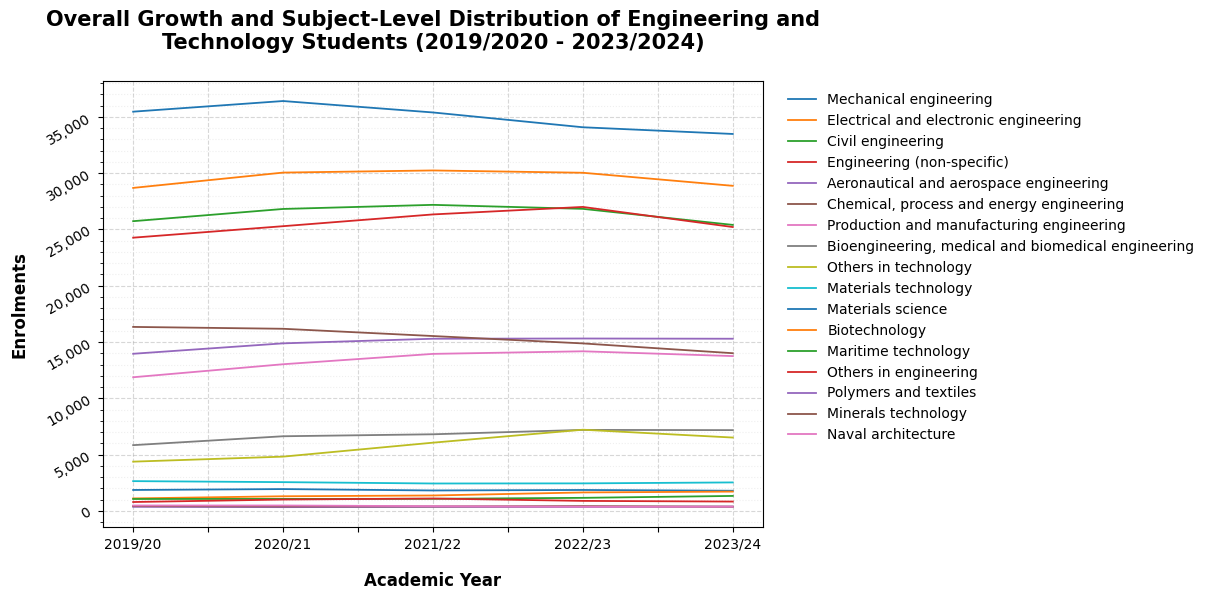

In [667]:
pvt = filter(df_keep, cah=CUSTOM_CAH)
plot_lines(pvt, TITLE, YLABEL, "all_eng_and_tech_students_lines", chart_dir="chart-1")